# Direct method example

An example use of isoclassify's direct method. Prefered use is through the command-line interface (see README).

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os 
import h5py
import numpy as np
import astropy.units as units

from isoclassify import DATADIR
from isoclassify.direct import classify as classify_direct
from isoclassify.extinction import query_dustmodel_coords

## Bolometric corrections model

Load the BC model.

In [2]:
fn = os.path.join(DATADIR,'bcgrid.h5')
bcmodel = h5py.File(fn,'r', driver='core', backing_store=False)

## Reddening maps

We first initialise the observational data and give it some arbitrary coordinates.

In [3]:
x = classify_direct.obsdata()
x.addcoords(292.0826387546914, 37.05987401545169)

We then specify the reddening (dust) map to use. Here, we choose [Green et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019ApJ...887...93G/abstract), a.k.a. Bayestar19 (see [here](http://argonaut.skymaps.info/usage#intro) for more information).

If we don't want to use a reddening map, isoclassify fits for Av. In this case specify `dustmap = 'none'`. Alternatively, if you want to assume no reddening, use `dustmap = 'zero'`. In both cases, the [Cardelli et al. (1989)](https://ui.adsabs.harvard.edu/abs/1989ApJ...345..245C/abstract) reddening law is assumed.

In [4]:
dustmap = 'green19'
dustmodel, ext = query_dustmodel_coords(x.ra, x.dec, dustmap)

## Observational data

We add some observational data for the star.

In [5]:
# SPECTROSCOPY 
# [Teff, logg, FeH] and [sigma_Teff, sigma_logg, sigma_FeH] 
x.addspec([5777.,4.44,0.0],[60.,0.07,0.04])

# PARALLAX
x.addplx(0.07,0.007)

# 2MASS PHOTOMETRY
x.addjhk([4.38,4.04,4.00],[0.03,0.03,0.03])

# MAGNITUDE
# To use for the distance modulus
x.addmag([4.38],[0.03])

## Fit

We perform the fit using isoclassify's direct method and the inputs described above.

using max distance: 24.0
using min distance: 10.0
   
teff(K): 5777.0 +/- 60.0
dis(pc): 14.90508905089051 + 1.7619176191761916 - 1.4246542465424668
av(mag): 0.0 + 0.0 - 0.0
rad(rsun): 1.06732286187634 + 0.13029215485924883 - 0.1064081998143106
lum(lsun): 1.1395019245124087 + 0.2884433075690864 - 0.2115007716403795
mabs( jmag ): 3.5122724061803465 + 0.222916368127148 - 0.24499121918116806
mass(msun): 0.0 + 0.0 - 0.0
density(rhosun): 0.0 + 0.0 - 0.0
-----


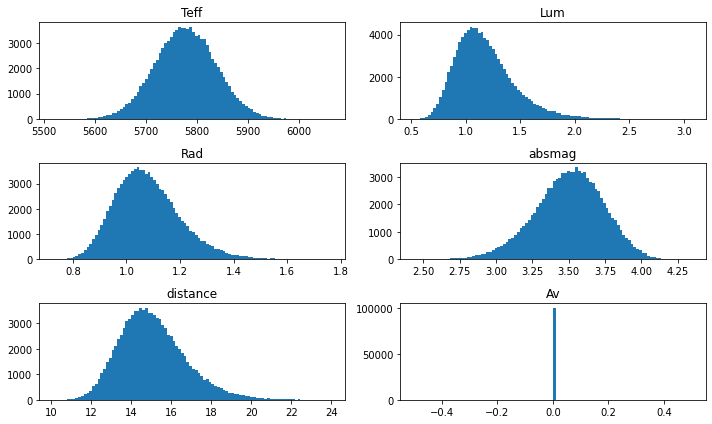

In [6]:
paras = classify_direct.stparas(x, bcmodel=bcmodel, dustmodel=dustmodel, band='jmag', ext=ext, plot=1)

NB: currently, spread on the Av posterior is only due to its variation within the distance uncertainty. It appears Bayestar19 varies very little with distance, hence the extremely narrow posterior. An assumed uncertainty of 0.02 is made in the code for the propagation of uncertainty.